<a href="https://colab.research.google.com/github/JunEden/Tensorflow/blob/main/20211028model_v4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

In [ ]:
poos_re = glob.glob("train_1/poo_p*")
for i in range(2,7):
  temp = glob.glob(f"train_{i}/poo_p*")
  poos_re += temp

poos_no = glob.glob("train_no/nopoo_p*") #不正常便

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# 不正常便的訓練資料才會做資料增強，先分訓練跟測試
poos_no_trian, poos_no_test = train_test_split(poos_no, test_size=0.1)
poos_re_trian, poos_re_test = train_test_split(poos_re, test_size=0.1) 

In [ ]:
img_gen = ImageDataGenerator(
    rotation_range=10,    # 角度值，0~180，影象旋轉
    width_shift_range=0.0,  # 水平平移，相對總寬度的比例
    height_shift_range=0.0,  # 垂直平移，相對總高度的比例
    shear_range=0.0,      # 隨機錯切換角度
    zoom_range=0.0,       # 隨機縮放範圍
    horizontal_flip=False,    # 一半影象水平翻轉
    vertical_flip=False,     # 一半影象垂直翻轉
    brightness_range=[0.7,1.3],     #亮度
    fill_mode='nearest'      # 填充新建立畫素的方法
)

(224, 224, 3)
(1, 224, 224, 3)


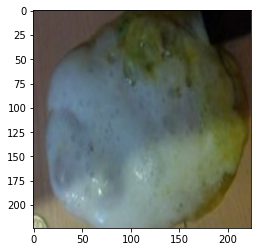

In [ ]:
# 隨機取單張照片做資料增強前設定
p = poos_no_trian
idx = random.randint(0, len(p)-1)
img_no = Image.open(p[idx]).resize((224, 224)).convert("RGB")
img_no = np.array(img_no)
img_no_re = img_no.reshape((1,) + img_no.shape)
plt.imshow(img_no)
print(img_no.shape)
print(img_no_re.shape)

In [ ]:
p[idx][9:-4]

'nopoo_p (92)'

In [ ]:
# 單張照片做資料增強測試
i = 0
poo_aug = []
for batch in img_gen.flow(img_no_re, batch_size=4):
  augImage = batch[0]
  img_au = augImage.astype("uint8") 
  img_t = Image.fromarray(img_au)
  img_t.save("/content/badpooaug/" + p[idx][9:-4] + "-{}.jpg".format(i)) #這邊手動建badpooaug資料夾做儲存，可以改用指令新建資料夾
  i += 1
  if i > 3:
    break

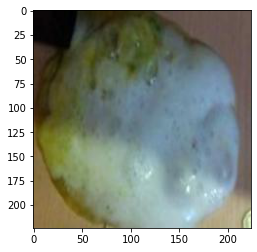

In [ ]:
img_test = Image.open("/content/badpooaug/nopoo_p (92)-0.jpg").resize((224, 224)).convert("RGB")
plt.imshow(img_test)

In [ ]:
# 不正常便的訓練資料做資料增強後，先儲存照片
p = poos_no_trian
for idx1 in range(len(p)):
  img_no = Image.open(p[idx1]).resize((224, 224)).convert("RGB")
  img_no = np.array(img_no)
  img_no_re = img_no.reshape((1,) + img_no.shape)
  i = 0
  for batch in img_gen.flow(img_no_re, batch_size=4):
    augImage = batch[0]
    img_au = augImage.astype("uint8")
    img_t = Image.fromarray(img_au)
    img_t.save("/content/badpooaug/" + p[idx1][9:-4] + "-{}.jpg".format(i))
    i += 1
    if i > 3:
      break

In [ ]:
poos_noaug = glob.glob("badpooaug/nopoo_p*")
# len(poos_noaug)
df_train = pd.DataFrame({
    "path":poos_re_trian + poos_no_trian + poos_noaug,
    "ans":[0] * len(poos_re_trian) + [1] * (len(poos_no_trian) + len(poos_noaug))
})
df_test = pd.DataFrame({
    "path":poos_re_test + poos_no_test,
    "ans":[0] * len(poos_re_test) + [1] * len(poos_no_test)
})

In [ ]:
x_train = np.array(df_train["path"])
y_train = np.array(df_train["ans"])
x_test = np.array(df_test["path"])
y_test = np.array(df_test["ans"])

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1439,)
(128,)
(1439,)
(128,)


# VGG16 引用

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
cnn.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization
layers = [
    BatchNormalization(), # 訓練前將拿來使用的卷積模型先做標準化及優化處理
    GlobalAveragePooling2D(),
    Dense(2, activation="softmax")       
]
# 卷積模型不參與訓練，要在 compile 前設定好
for l in cnn.layers:
  l.trainable = False
model = Sequential(cnn.layers + layers)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer="adam",
              metrics=["accuracy"])

In [ ]:
def data_generator(x, y, batch_size=30):
    while True:
        idx = np.random.randint(0, len(x), size=batch_size)
        x_batch, y_batch = x[idx], y[idx]
        x_final = []
        for path in x_batch:
            img = Image.open(path).resize((224, 224)).convert("RGB")
            img_pre = preprocess_input(np.array(img))
            x_final.append(img_pre)
        x_final = np.array(x_final)
        y_batch = np.array(y_batch)
        yield (x_final, y_batch)
gen = data_generator(x_train, y_train)
x_gen, y_gen = gen.__next__()
print(x_gen.shape)
print(y_gen.shape)
# print(x_gen)
# print(y_gen)

(30, 224, 224, 3)
(30,)


In [ ]:
train_generator = data_generator(x_train, y_train)
test_generator = data_generator(x_test, y_test)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
]
model.fit_generator(train_generator,
          steps_per_epoch=40,
          epochs=15,
          validation_data=test_generator,
          validation_steps=5,
          callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
40/40 [==============================] - 198s 5s/step - loss: 0.5423 - accuracy: 0.7075 - val_loss: 0.5849 - val_accuracy: 0.7667
Epoch 2/15
40/40 [==============================] - 194s 5s/step - loss: 0.3507 - accuracy: 0.8583 - val_loss: 0.4077 - val_accuracy: 0.8400
Epoch 3/15
40/40 [==============================] - 182s 5s/step - loss: 0.3308 - accuracy: 0.8433 - val_loss: 0.3183 - val_accuracy: 0.8933
Epoch 4/15
40/40 [==============================] - 173s 4s/step - loss: 0.2935 - accuracy: 0.8817 - val_loss: 0.3938 - val_accuracy: 0.8600
Epoch 5/15
40/40 [==============================] - 176s 4s/step - loss: 0.2502 - accuracy: 0.9150 - val_loss: 0.3295 - val_accuracy: 0.8667
Epoch 6/15
40/40 [==============================] - 169s 4s/step - loss: 0.2374 - accuracy: 0.9183 - val_loss: 0.3228 - val_accuracy: 0.8733
Epoch 7/15
40/40 [==============================] - 177s 5s/step - loss: 0.2192 - accuracy: 0.9233 - val_loss: 0.3306 - val_accuracy: 0.8800
Epoch 8/15
40

In [ ]:
model.save("poo_aug_v4.h5")

In [ ]:
testx, testy = test_generator.__next__()
model.predict(testx)

array([[0.95657295, 0.04342709],
       [0.02288439, 0.97711563],
       [0.83280194, 0.16719805],
       [0.97506434, 0.02493571],
       [0.9401294 , 0.05987058],
       [0.9767347 , 0.02326525],
       [0.91627455, 0.08372548],
       [0.9672693 , 0.03273071],
       [0.82232034, 0.17767967],
       [0.94836766, 0.05163227],
       [0.9144604 , 0.08553952],
       [0.98603266, 0.01396726],
       [0.9591995 , 0.04080052],
       [0.9820033 , 0.01799669],
       [0.9287174 , 0.07128268],
       [0.8170941 , 0.18290597],
       [0.76739806, 0.23260194],
       [0.9896237 , 0.01037629],
       [0.91353685, 0.08646311],
       [0.95086175, 0.04913821]], dtype=float32)

In [ ]:
ori_imgs = []
for p in x_test:
    img = Image.open(p).resize((224, 224)).convert("RGB")
    ori_imgs.append(np.array(img))
ori_imgs = np.array(ori_imgs)
preprocess_imgs = preprocess_input(ori_imgs)

In [ ]:
pre = model.predict(preprocess_imgs).argmax(axis=1)
trans = ["good", "Bad"]
idx = np.nonzero(pre != y_test)[0]
pre_false_img = ori_imgs[idx]
pre_false_val = pre[idx]
pre_false_ori = y_test[idx]

plt.figure(figsize=(30, 30))
width = 10
height = len(idx) // width + 1
for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    t = "[O]:{}\n[P]:{}".format(trans[pre_false_ori[i]],
                                trans[pre_false_val[i]])
    plt.title(t)
    plt.axis("off")
    plt.imshow(pre_false_img[i])

In [ ]:
import requests
url = input("Enter:")
response = requests.get(url, stream=True, verify=False)
img = Image.open(response.raw).resize((224, 224)).convert("RGB")
img_np = preprocess_input(np.array(img).reshape(1, 224, 224, 3))
proba = model.predict(img_np)
ans = proba.argmax(axis=1)
print("預測:", trans[ans[0]])
print("機率:", proba[0])
plt.imshow(img)